In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 2500.0
bigT = 2000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570486533  X= 20.0997201994404
A2=  -0.49962370647516496  X= 40.0
A2=  -0.5019378672698831  X= 16.740033480066963
A2=  -0.5018381151222431  X= 21.703563407126815
A2=  -0.501873065422044  X= 15.347950695901392
A2=  -0.5019294650803621  X= 13.257546515093031
A2=  -0.5019294650803621  X= 13.257546515093031
MU= 0.31816194102760903 MASS= 0.09999058237901089


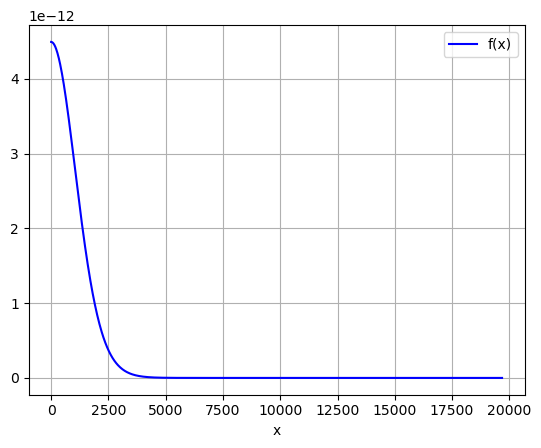

(1000,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

psi = x*psi

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DX:", dx)
print("DT:", dt)

[0.00271691+0.j 0.00814509+0.j 0.0135564 +0.j 0.01893967+0.j
 0.02428383+0.j 0.02957797+0.j 0.03481139+0.j 0.03997361+0.j
 0.04505445+0.j 0.05004403+0.j 0.05493283+0.j 0.05971172+0.j
 0.06437198+0.j 0.06890537+0.j 0.0733041 +0.j 0.0775609 +0.j
 0.081669  +0.j 0.0856222 +0.j 0.08941485+0.j 0.09304187+0.j
 0.09649875+0.j 0.09978158+0.j 0.10288704+0.j 0.1058124 +0.j
 0.1085555 +0.j 0.11111479+0.j 0.11348927+0.j 0.11567851+0.j
 0.11768263+0.j 0.11950228+0.j 0.12113861+0.j 0.12259328+0.j
 0.12386842+0.j 0.12496659+0.j 0.12589077+0.j 0.12664436+0.j
 0.12723111+0.j 0.12765509+0.j 0.1279207 +0.j 0.12803263+0.j
 0.12799579+0.j 0.12781533+0.j 0.12749659+0.j 0.12704508+0.j
 0.12646643+0.j 0.12576638+0.j 0.12495077+0.j 0.12402548+0.j
 0.12299642+0.j 0.12186952+0.j 0.12065069+0.j 0.1193458 +0.j
 0.11796069+0.j 0.11650109+0.j 0.11497269+0.j 0.11338103+0.j
 0.11173157+0.j 0.11002963+0.j 0.10828038+0.j 0.10648886+0.j
 0.10465993+0.j 0.10279831+0.j 0.10090854+0.j 0.09899497+0.j
 0.0970618 +0.j 0.095113

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T
    for i in range(size):
        if i==0:
            T[i][i] = -3.0
            T[i][i+1] = 1.0
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0

    T = -1.0/2.0/dx/dx*T

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i]/x[i])*np.absolute(psi[i]/x[i])

def setupV2Grav():
    global V2Grav, phi

    rho = np.absolute(psi)*np.absolute(psi)/x/x
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+Q+V2Grav)

0 0.0 0.058397622813581386
1 0.08351027137908527 0.058400714819429884
2 0.16702054275817055 0.05840586330826538
3 0.2505308141372558 0.05841305945553183
4 0.3340410855163411 0.05842229210932936
5 0.4175513568954264 0.05843354655121007
6 0.5010616282745116 0.05844680491636354
7 0.5845718996535969 0.05846204706159754
8 0.6680821710326822 0.05847924980009118
9 0.7515924424117675 0.058498387065234185
10 0.8351027137908528 0.058519431013034244
11 0.9186129851699381 0.05854235101691093
12 1.0021232565490232 0.05856711489187082
13 1.0856335279281086 0.058593688420087664
14 1.1691437993071938 0.058622036279628954
15 1.2526540706862792 0.05865212155313651
16 1.3361643420653644 0.05868390536631791
17 1.4196746134444496 0.058717349062960646
18 1.503184884823535 0.05875241177160779
19 1.5866951562026201 0.0587890548308191
20 1.6702054275817055 0.05882723579820867
21 1.7537156989607907 0.0588669150020135
22 1.8372259703398761 0.05890804998774188
23 1.9207362417189613 0.058950599833746106
24 2.00424

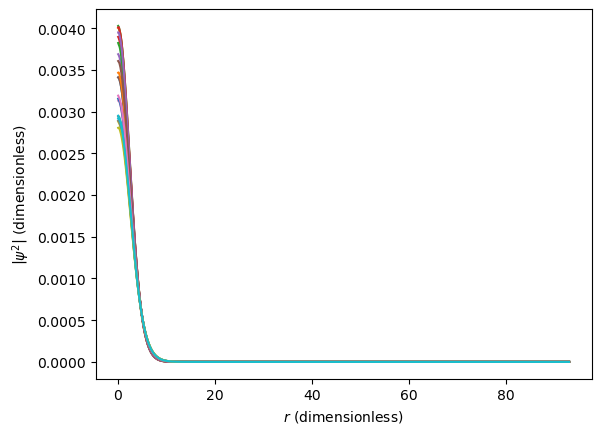

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

hello = []
hello2 = []
hello3 = []
hello4 = []
ts = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(t*dt<6.0):
        GM = newGM
    if(t*dt>=6.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    print(t, t*dt, np.absolute(psi[0])/x[0])
    if(GM == oldGM):

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello4.append(np.angle(psi[1]))
        hello3.append(np.angle(psi[0]))
        hello2.append(findMass())
        hello.append(np.absolute(psi[0])*np.absolute(psi[0])/x[0]/x[0])
        ts.append(t*dt)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

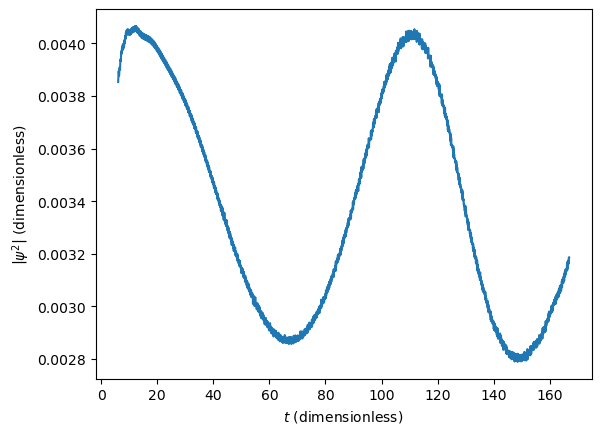

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

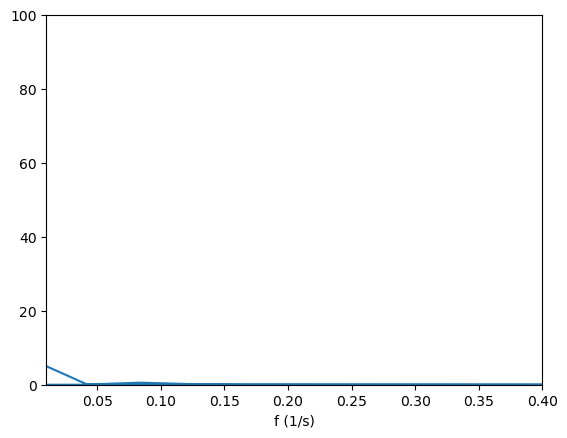

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100.0)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.04211970954356847
0.08423941908713695 0.5547414884864186
0.21059854771784234 0.057670957053530085


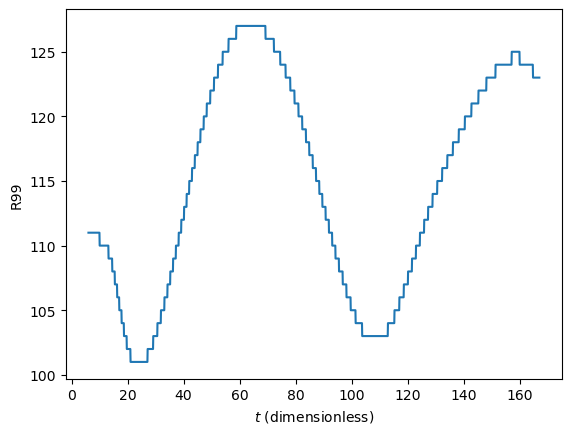

In [11]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

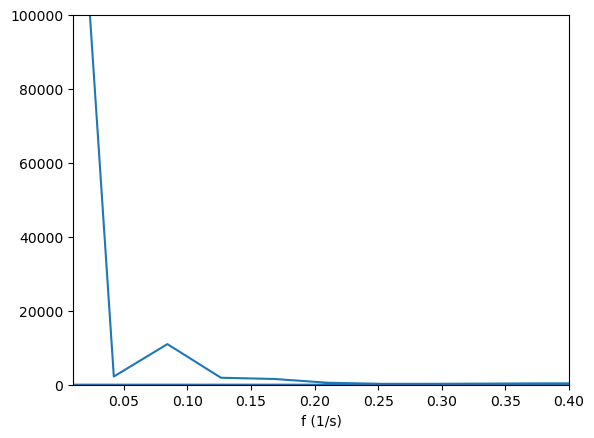

In [12]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [13]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.04211970954356847
0.08423941908713695 10988.767597010057


[5.64506879e-02 5.64125108e-02 5.63180633e-02 5.61844932e-02
 5.60269295e-02 5.58352114e-02 5.56117897e-02 5.53549088e-02
 5.50558531e-02 5.47236612e-02 5.43587146e-02 5.39585895e-02
 5.35310716e-02 5.30694725e-02 5.25750507e-02 5.20564281e-02
 5.15072868e-02 5.09337325e-02 5.03375886e-02 4.97105402e-02
 4.90631532e-02 4.83945493e-02 4.77020639e-02 4.69965982e-02
 4.62698672e-02 4.55240606e-02 4.47689761e-02 4.39964698e-02
 4.32152476e-02 4.24270897e-02 4.16226011e-02 4.08133081e-02
 3.99967683e-02 3.91715729e-02 3.83493865e-02 3.75217935e-02
 3.66911701e-02 3.58639198e-02 3.50324225e-02 3.42046154e-02
 3.33815990e-02 3.25583747e-02 3.17425588e-02 3.09319157e-02
 3.01267333e-02 2.93320381e-02 2.85446734e-02 2.77659332e-02
 2.69969278e-02 2.62375262e-02 2.54890257e-02 2.47520448e-02
 2.40278834e-02 2.33142588e-02 2.26136156e-02 2.19270256e-02
 2.12517220e-02 2.05926814e-02 1.99466254e-02 1.93117177e-02
 1.86931610e-02 1.80861917e-02 1.74938769e-02 1.69186876e-02
 1.63553715e-02 1.580753

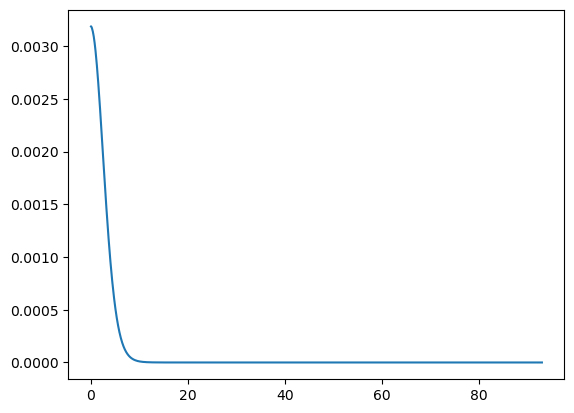

In [14]:
plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)
print(np.absolute(psi)/x)

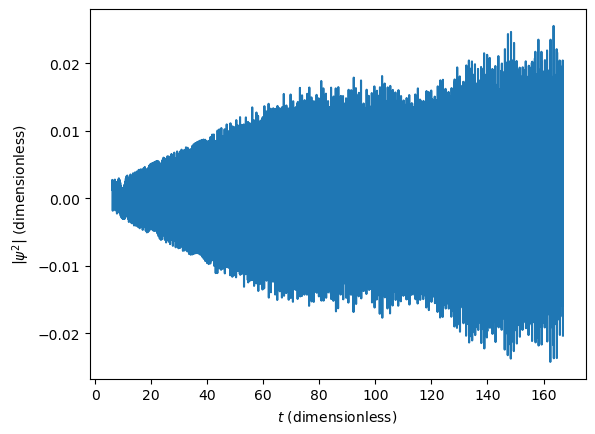

In [15]:
plt.plot(ts, (np.array(hello4)-np.array(hello3))/(dx*Ra)/m/Ra/omegaA*dt/dx)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?